In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [2]:
REBUILD_DATA = True


class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

PetImages/Cat


100%|████████████████████████████████████████████████████████████████████████████| 10183/10183 [05:27<00:00, 31.13it/s]


PetImages/Dog


100%|██████████████████████████████████████████████████████████████████████████████| 5969/5969 [02:36<00:00, 38.18it/s]
C:\Users\DELL\anaconda3\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


Cats: 10167
Dogs: 5956


This code defines a class called DogsVSCats, which is used to create a dataset of images of cats and dogs. The images are loaded using the OpenCV library, resized to a fixed size, and then stored as numpy arrays along with their corresponding labels (0 for cats, 1 for dogs). The make_training_data() method reads the images from the file system, preprocesses them and stores them in a list called training_data. The images and labels are then shuffled randomly, and saved to a file named "training_data.npy" using the numpy.save() method. The variable REBUILD_DATA controls whether the data should be rebuilt or loaded from the saved file. If it is set to True, the make_training_data() method will be called to build the data from scratch, otherwise the saved file will be loaded.

In [3]:
training_data = np.load("training_data.npy", allow_pickle=True)
print(len(training_data))

16123


In [4]:
import torch

X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

C:\Users\DELL\AppData\Local\Temp\ipykernel_8248\116574787.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)


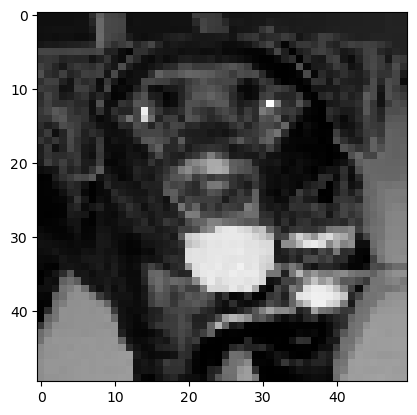

In [5]:
import matplotlib.pyplot as plt

plt.imshow(X[0], cmap="gray")

In [6]:
print(y[0])

tensor([0., 1.])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__() # just run the init of parent class (nn.Module)
        self.conv1 = nn.Conv2d(1, 32, 5) # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5) # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 512) #flattening.
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  # .view is reshape ... this flattens X before 
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


In [9]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

In [10]:
X = torch.Tensor([i[0] for i in training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

In [11]:
VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)

1612


In [12]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]
print(len(train_X), len(test_X))

14511 1612


In [13]:
BATCH_SIZE = 100
EPOCHS = 8

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)): # from 0, to the len of x, stepping BATCH_SIZE at a time. [:50] ..for now just to dev
        #print(f"{i}:{i+BATCH_SIZE}")
        batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
        batch_y = train_y[i:i+BATCH_SIZE]

        net.zero_grad()

        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    # Does the update

    print(f"Epoch: {epoch}. Loss: {loss}")

100%|████████████████████████████████████████████████████████████████████████████████| 146/146 [02:15<00:00,  1.08it/s]


Epoch: 0. Loss: 0.24823574721813202


100%|████████████████████████████████████████████████████████████████████████████████| 146/146 [02:05<00:00,  1.16it/s]


Epoch: 1. Loss: 0.22295084595680237


100%|████████████████████████████████████████████████████████████████████████████████| 146/146 [02:04<00:00,  1.18it/s]


Epoch: 2. Loss: 0.21916605532169342


100%|████████████████████████████████████████████████████████████████████████████████| 146/146 [01:56<00:00,  1.26it/s]


Epoch: 3. Loss: 0.18138524889945984


100%|████████████████████████████████████████████████████████████████████████████████| 146/146 [02:20<00:00,  1.04it/s]


Epoch: 4. Loss: 0.12766146659851074


100%|████████████████████████████████████████████████████████████████████████████████| 146/146 [02:14<00:00,  1.08it/s]


Epoch: 5. Loss: 0.06717973202466965


100%|████████████████████████████████████████████████████████████████████████████████| 146/146 [01:52<00:00,  1.30it/s]


Epoch: 6. Loss: 0.021937228739261627


100%|████████████████████████████████████████████████████████████████████████████████| 146/146 [02:04<00:00,  1.17it/s]


Epoch: 7. Loss: 0.014670837670564651


In [14]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1, 1, 50, 50))[0]  # returns a list, 
        predicted_class = torch.argmax(net_out)

        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total, 3))

100%|█████████████████████████████████████████████████████████████████████████████| 1612/1612 [00:07<00:00, 201.73it/s]

Accuracy:  0.762
